In [1]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

from data_preprocessing import DataPreprocessor
from feature_engineering import FeatureEngineer
from model_training import ModelTrainer
from entity_extraction import EntityExtractor

print("Customer Support Ticket Classification Pipeline")
print("="*60)
print("All imports successful!")


Customer Support Ticket Classification Pipeline
All imports successful!


In [2]:
print("Loading data...")
preprocessor = DataPreprocessor()
df = preprocessor.load_data('../data/ai_dev_assignment_tickets_complex_1000.xlsx')

if df is not None:
    df = preprocessor.explore_data(df)
    print("Data loaded and explored successfully!")
else:
    print("Failed to load data. Please check the file path.")
    print("Expected location: ../data/ai_dev_assignment_tickets_complex_1000.xlsx")


Loading data...
Data loaded successfully. Shape: (1000, 5)

DATA EXPLORATION
Dataset shape: (1000, 5)

Missing values:
ticket_id         0
ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64

Issue type distribution:
issue_type
Billing Problem       146
General Inquiry       146
Account Access        143
Installation Issue    142
Product Defect        121
Wrong Item            114
Late Delivery         112
Name: count, dtype: int64

Urgency level distribution:
urgency_level
High      330
Medium    319
Low       299
Name: count, dtype: int64

Product distribution:
product
RoboChef Blender     116
Vision LED TV        109
PhotoSnap Cam        103
FitRun Treadmill     102
PowerMax Battery     102
EcoBreeze AC         100
ProTab X1             99
SmartWatch V2         95
SoundWave 300         90
UltraClean Vacuum     84
Name: count, dtype: int64

SAMPLE TICKETS

Ticket 1:
Text: Payment issue for my SmartWatch V2. I was underbilled for order #29224..

In [3]:
print("Starting data preprocessing...")
df_processed = preprocessor.preprocess_data(df)
print("Data preprocessing completed!")

# Save processed data
os.makedirs('../models', exist_ok=True)
df_processed.to_csv('../models/processed_data.csv', index=False)
print("Processed data saved to ../models/processed_data.csv")

print("\nSample processed data:")
sample_df = df_processed[['ticket_text', 'processed_text', 'sentiment', 'text_length']].head(3)
for idx, row in sample_df.iterrows():
    print(f"\n--- Sample {idx+1} ---")
    print(f"Original: {row['ticket_text'][:100]}...")
    print(f"Processed: {row['processed_text'][:100]}...")
    print(f"Sentiment: {row['sentiment']:.3f}, Length: {row['text_length']}")


Starting data preprocessing...

PREPROCESSING DATA
Cleaning text...
Adding text features...
Tokenizing...
Preprocessing completed! Final shape: (1000, 11)
Data preprocessing completed!
Processed data saved to ../models/processed_data.csv

Sample processed data:

--- Sample 1 ---
Original: Payment issue for my SmartWatch V2. I was underbilled for order #29224....
Processed: payment issue smartwatch underbilled order...
Sentiment: 0.000, Length: 65

--- Sample 2 ---
Original: Can you tell me more about the UltraClean Vacuum warranty? Also, is it available in white?...
Processed: tell ultraclean vacuum warranty also available white...
Sentiment: 0.223, Length: 89

--- Sample 3 ---
Original: I ordered SoundWave 300 but got EcoBreeze AC instead. My order number is #36824....
Processed: ordered soundwave got ecobreeze instead order number...
Sentiment: 0.000, Length: 70


In [4]:
print("Starting feature engineering...")
feature_engineer = FeatureEngineer()
X, df_final = feature_engineer.create_all_features(df_processed)
print("Feature engineering completed!")

print(f"\nFinal dataset info:")
print(f"Features shape: {X.shape}")
print(f"Issue types: {df_final['issue_type'].unique()}")
print(f"Urgency levels: {df_final['urgency_level'].unique()}")

print("\nClass Distribution Analysis:")
print("\nIssue Type Distribution:")
print(df_final['issue_type'].value_counts())
print("\nUrgency Level Distribution:")
print(df_final['urgency_level'].value_counts())


Starting feature engineering...

FEATURE ENGINEERING
Encoding labels...
Issue types: ['Account Access' 'Billing Problem' 'General Inquiry' 'Installation Issue'
 'Late Delivery' 'Product Defect' 'Unknown' 'Wrong Item']
Urgency levels: ['High' 'Low' 'Medium']
Creating TF-IDF features...
Created 406 TF-IDF features
Creating additional features...
Created 15 additional features
Feature engineering completed! Feature matrix shape: (1000, 421)
Feature engineering completed!

Final dataset info:
Features shape: (1000, 421)
Issue types: ['Billing Problem' 'General Inquiry' 'Wrong Item' 'Installation Issue'
 'Late Delivery' 'Product Defect' 'Unknown' 'Account Access']
Urgency levels: ['Medium' 'Low' 'High']

Class Distribution Analysis:

Issue Type Distribution:
issue_type
Billing Problem       146
General Inquiry       146
Account Access        143
Installation Issue    142
Product Defect        121
Wrong Item            114
Late Delivery         112
Unknown                76
Name: count, dtyp

In [5]:
print("Starting model training...")
trainer = ModelTrainer()

y_issue = df_final['issue_type_encoded']
y_urgency = df_final['urgency_level_encoded']

X_train, X_test, y_issue_train, y_issue_test, y_urgency_train, y_urgency_test = trainer.split_data(
    X, y_issue, y_urgency
)

print("Training models...")
issue_model = trainer.train_issue_classifier(X_train, y_issue_train, X_test, y_issue_test)
urgency_model = trainer.train_urgency_classifier(X_train, y_urgency_train, X_test, y_urgency_test)
print("Model training completed!")


Starting model training...
Training set size: 800
Test set size: 200
Training models...

TRAINING ISSUE TYPE CLASSIFIER
Data balanced: 800 -> 936 samples

Training RandomForest...
RandomForest CV Score: 0.8419 (+/- 0.0258)
RandomForest Test Score: 0.8650

Training LogisticRegression...
LogisticRegression CV Score: 0.7970 (+/- 0.0378)
LogisticRegression Test Score: 0.8250

Best Issue Classifier: RandomForest (Score: 0.8650)

TRAINING URGENCY LEVEL CLASSIFIER
Data balanced: 800 -> 894 samples

Training RandomForest...
RandomForest CV Score: 0.3669 (+/- 0.0580)
RandomForest Test Score: 0.3450

Training LogisticRegression...
LogisticRegression CV Score: 0.3647 (+/- 0.0644)
LogisticRegression Test Score: 0.3100

Best Urgency Classifier: RandomForest (Score: 0.3450)
Model training completed!


Evaluating models...

ISSUE TYPE CLASSIFIER EVALUATION

ISSUE CLASSIFIER EVALUATION
Accuracy: 0.8650

Classification Report:
                    precision    recall  f1-score   support

    Account Access       0.90      0.97      0.93        29
   Billing Problem       0.96      0.90      0.93        29
   General Inquiry       0.93      0.93      0.93        29
Installation Issue       0.93      0.86      0.89        29
     Late Delivery       0.63      1.00      0.77        22
    Product Defect       0.92      0.92      0.92        24
           Unknown       0.33      0.07      0.11        15
        Wrong Item       0.92      0.96      0.94        23

          accuracy                           0.86       200
         macro avg       0.81      0.82      0.80       200
      weighted avg       0.85      0.86      0.85       200



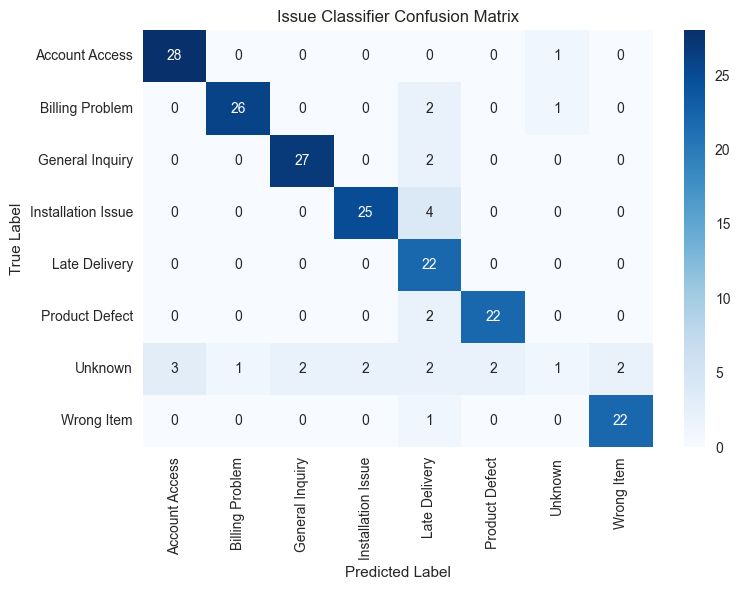


URGENCY LEVEL CLASSIFIER EVALUATION

URGENCY CLASSIFIER EVALUATION
Accuracy: 0.3450

Classification Report:
              precision    recall  f1-score   support

        High       0.28      0.34      0.30        62
         Low       0.36      0.23      0.28        65
      Medium       0.40      0.45      0.43        73

    accuracy                           0.34       200
   macro avg       0.35      0.34      0.34       200
weighted avg       0.35      0.34      0.34       200



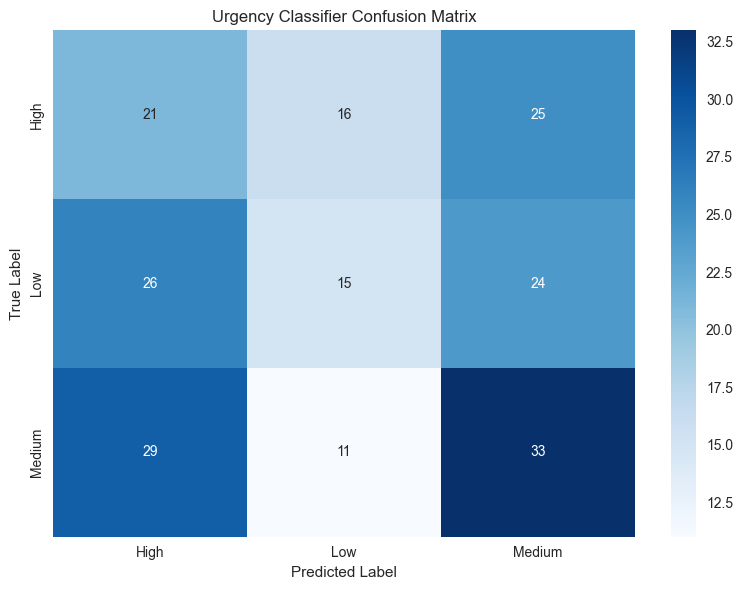


FINAL RESULTS:
Issue Type Accuracy: 0.8650
Urgency Level Accuracy: 0.3450


In [6]:
print("Evaluating models...")

print("\nISSUE TYPE CLASSIFIER EVALUATION")
print("="*60)
issue_accuracy, issue_predictions = trainer.evaluate_model(
    issue_model, X_test, y_issue_test, 
    feature_engineer.label_encoders['issue_type'], 'Issue Classifier'
)

print("\nURGENCY LEVEL CLASSIFIER EVALUATION")
print("="*60)
urgency_accuracy, urgency_predictions = trainer.evaluate_model(
    urgency_model, X_test, y_urgency_test, 
    feature_engineer.label_encoders['urgency_level'], 'Urgency Classifier'
)

print(f"\nFINAL RESULTS:")
print(f"Issue Type Accuracy: {issue_accuracy:.4f}")
print(f"Urgency Level Accuracy: {urgency_accuracy:.4f}")


Saving models...
Models saved to ../models/
Feature objects saved to ../models/
Models saved successfully!


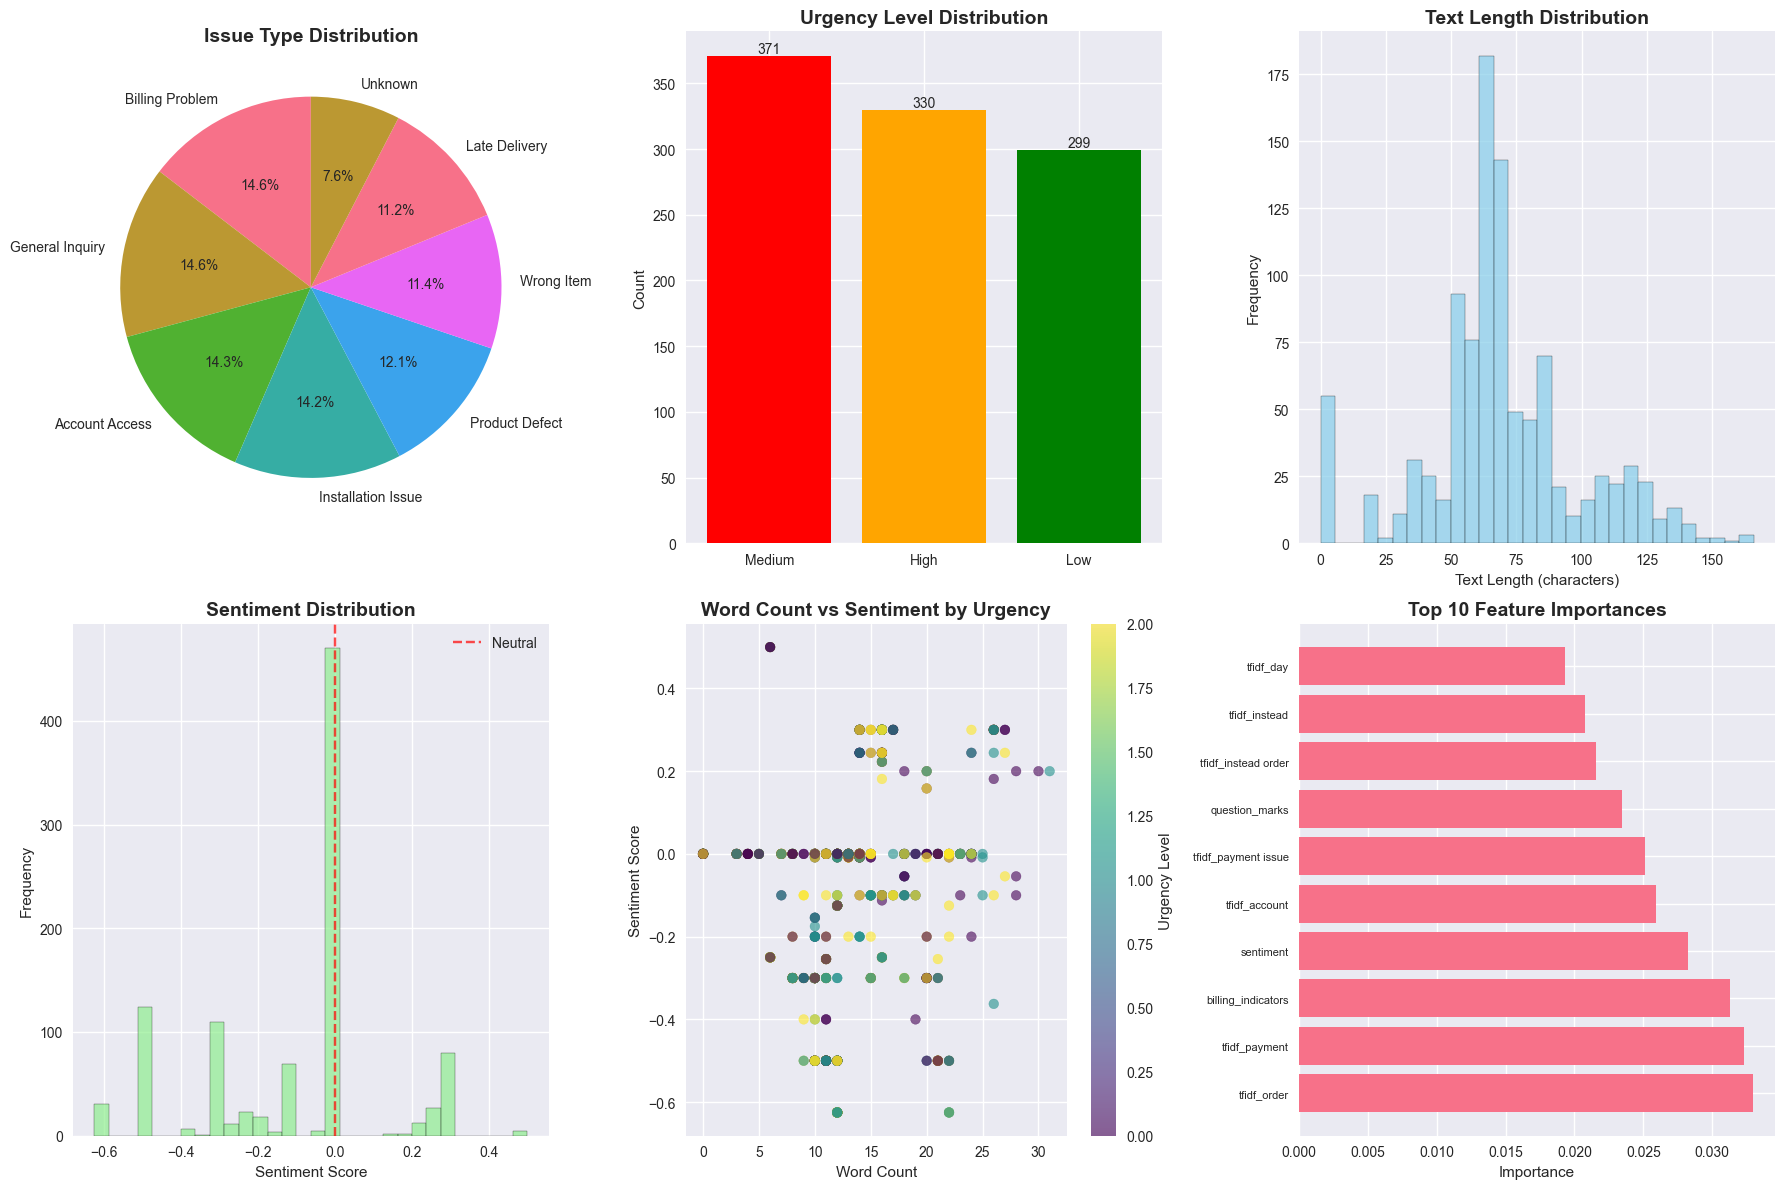

Visualizations completed!


In [7]:
print("Saving models...")
trainer.save_models('../models/')
feature_engineer.save_feature_objects('../models/')
print("Models saved successfully!")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Issue type distribution
issue_counts = df_final['issue_type'].value_counts()
axes[0, 0].pie(issue_counts.values, labels=issue_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Issue Type Distribution', fontsize=14, fontweight='bold')

# Urgency level distribution
urgency_counts = df_final['urgency_level'].value_counts()
bars = axes[0, 1].bar(urgency_counts.index, urgency_counts.values, color=['red', 'orange', 'green'])
axes[0, 1].set_title('Urgency Level Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Count')
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

# Text length distribution
axes[0, 2].hist(df_final['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 2].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Text Length (characters)')
axes[0, 2].set_ylabel('Frequency')

# Sentiment distribution
axes[1, 0].hist(df_final['sentiment'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[1, 0].legend()

# Word count vs Sentiment scatter
scatter = axes[1, 1].scatter(df_final['word_count'], df_final['sentiment'], 
                           c=df_final['urgency_level_encoded'], alpha=0.6, cmap='viridis')
axes[1, 1].set_title('Word Count vs Sentiment by Urgency', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Sentiment Score')
plt.colorbar(scatter, ax=axes[1, 1], label='Urgency Level')

# Feature importance
if hasattr(issue_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': issue_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1, 2].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[1, 2].set_yticks(range(len(feature_importance)))
    axes[1, 2].set_yticklabels(feature_importance['feature'], fontsize=8)
    axes[1, 2].set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Importance')
else:
    axes[1, 2].text(0.5, 0.5, 'Feature importance\nnot available\nfor this model', 
                   ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualizations completed!")


In [8]:
print("Testing entity extraction...")
extractor = EntityExtractor()

sample_tickets = df['ticket_text'].head(5).tolist()

print("\nENTITY EXTRACTION TESTING")
print("="*60)

for i, ticket in enumerate(sample_tickets):
    print(f"\n--- Ticket {i+1} ---")
    print(f"Text: {ticket[:150]}...")
    
    entities = extractor.extract_all_entities(ticket)
    
    for key, value in entities.items():
        if value:
            if isinstance(value, dict):
                for sub_key, sub_value in value.items():
                    if sub_value:
                        print(f"  {key}.{sub_key}: {sub_value}")
            else:
                print(f"  {key}: {value}")

print("Entity extraction testing completed!")


Testing entity extraction...

ENTITY EXTRACTION TESTING

--- Ticket 1 ---
Text: Payment issue for my SmartWatch V2. I was underbilled for order #29224....
  products: ['smartwatch', 'SmartWatch V2']
  complaint_keywords: ['issue', 'underbilled']
  order_numbers: ['order #29224', '#29224']

--- Ticket 2 ---
Text: Can you tell me more about the UltraClean Vacuum warranty? Also, is it available in white?...
  products: ['vacuum', 'ac', 'UltraClean Vacuum']

--- Ticket 3 ---
Text: I ordered SoundWave 300 but got EcoBreeze AC instead. My order number is #36824....
  products: ['ac', 'EcoBreeze AC', 'SoundWave 300']
  order_numbers: ['#36824']

--- Ticket 4 ---
Text: Facing installation issue with PhotoSnap Cam. Setup fails at step 1....
  products: ['ac', 'PhotoSnap Cam']
  complaint_keywords: ['issue']

--- Ticket 5 ---
Text: Order #30903 for Vision LED TV is 13 days late. Ordered on 03 March. Also, I contacted support on 03 March but got no response....
  products: ['ac', 'tv', 'Vision LE

In [9]:
print("Testing complete pipeline...")

from ticket_classifier import TicketClassifier

classifier = TicketClassifier()

test_tickets = [
    "Payment issue for my SmartWatch V2. I was underbilled for order #29224. I contacted support on 03 March but got no response.",
    "Facing installation issue with RoboChef Blender. Setup fails at step 3. This is urgent, please help immediately!",
    "Vision LED TV is malfunction. It stopped working after just 6 days.",
    "Can't log in to my account. Keeps showing unknown issue. Help!",
    "Order #30903 for Vision LED TV is 13 days late. Ordered on 03 March. Very frustrated!"
]

print("\nCOMPLETE PIPELINE TESTING")
print("="*60)

for i, ticket in enumerate(test_tickets):
    print(f"\n--- Test Ticket {i+1} ---")
    print(f"Input: {ticket}")
    
    result = classifier.predict_ticket(ticket)
    
    print(f"Issue Type: {result['predicted_issue_type']} (Confidence: {result['issue_confidence']:.2%})")
    print(f"Urgency: {result['predicted_urgency_level']} (Confidence: {result['urgency_confidence']:.2%})")
    
    entities = result['extracted_entities']
    if any(entities.values()):
        print("Entities:")
        for key, value in entities.items():
            if value:
                if isinstance(value, dict):
                    for sub_key, sub_value in value.items():
                        if sub_value:
                            print(f"   {sub_key}: {sub_value}")
                else:
                    print(f"   {key}: {value}")

print("Complete pipeline testing completed!")


Testing complete pipeline...
Models loaded from ../models/
Models loaded successfully!

COMPLETE PIPELINE TESTING

--- Test Ticket 1 ---
Input: Payment issue for my SmartWatch V2. I was underbilled for order #29224. I contacted support on 03 March but got no response.
Issue Type: Billing Problem (Confidence: 91.79%)
Urgency: High (Confidence: 57.40%)
Entities:
   products: ['ac', 'smartwatch', 'SmartWatch V2']
   dates: ['03 March']
   complaint_keywords: ['no response', 'issue', 'underbilled']
   order_numbers: ['order #29224', '#29224']
   contacted_support: True

--- Test Ticket 2 ---
Input: Facing installation issue with RoboChef Blender. Setup fails at step 3. This is urgent, please help immediately!
Issue Type: Installation Issue (Confidence: 71.41%)
Urgency: High (Confidence: 42.66%)
Entities:
   products: ['ac', 'RoboChef Blender', 'blender']
   complaint_keywords: ['issue']
   urgency_indicators: ['immediately', 'urgent', 'please help']

--- Test Ticket 3 ---
Input: Vision LED

In [10]:
print("\nFINAL PERFORMANCE SUMMARY")
print("="*60)

print(f"Issue Type Classifier Accuracy: {issue_accuracy:.2%}")
print(f"Urgency Level Classifier Accuracy: {urgency_accuracy:.2%}")

print(f"\nDataset Statistics:")
print(f"   Total tickets processed: {len(df_final)}")
print(f"   Number of features created: {X.shape[1]}")
print(f"   Issue types: {len(df_final['issue_type'].unique())}")
print(f"   Urgency levels: {len(df_final['urgency_level'].unique())}")

print(f"\nFeature Engineering:")
print(f"   TF-IDF features: {len([col for col in X.columns if col.startswith('tfidf_')])}")
print(f"   Additional features: {len([col for col in X.columns if not col.startswith('tfidf_')])}")

print(f"\nPROJECT COMPLETED SUCCESSFULLY!")
print(f"\nNext Steps:")
print(f"   1. Run the Gradio app: python ../src/gradio_app.py")
print(f"   2. Test with your own tickets")
print(f"   3. Upload batch files for processing")
print(f"   4. Create your demo video")

print(f"\nFiles created:")
print(f"   - Processed data: ../models/processed_data.csv")
print(f"   - Models saved in: ../models/")
print(f"   - Source code in: ../src/")
print(f"   - This analysis in: notebooks/main_analysis.ipynb")



FINAL PERFORMANCE SUMMARY
Issue Type Classifier Accuracy: 86.50%
Urgency Level Classifier Accuracy: 34.50%

Dataset Statistics:
   Total tickets processed: 1000
   Number of features created: 421
   Issue types: 8
   Urgency levels: 3

Feature Engineering:
   TF-IDF features: 406
   Additional features: 15

PROJECT COMPLETED SUCCESSFULLY!

Next Steps:
   1. Run the Gradio app: python ../src/gradio_app.py
   2. Test with your own tickets
   3. Upload batch files for processing
   4. Create your demo video

Files created:
   - Processed data: ../models/processed_data.csv
   - Models saved in: ../models/
   - Source code in: ../src/
   - This analysis in: notebooks/main_analysis.ipynb
